## DLib and OpenCV

In [2]:
# In the very first cell of your notebook, run:
!pip install --upgrade pip
!pip install dlib face_recognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 96.8 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'face-recognition-models' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'face-recognition-models'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=16875463c319bbe573c

✅ All libraries imported successfully!
📁 Loading dataset from: /kaggle/input/face-recognition-dataset/Original Images/Original Images
✅ Found 2562 images across 31 people

📊 DATASET STATISTICS
Total images: 2,562
Total people: 31
Average samples per person: 82.6
Min samples per person: 30
Max samples per person: 120

📋 Samples per person:
  Akshay Kumar: 50 images
  Alexandra Daddario: 92 images
  Alia Bhatt: 79 images
  Amitabh Bachchan: 74 images
  Andy Samberg: 92 images
  Anushka Sharma: 68 images
  Billie Eilish: 98 images
  Brad Pitt: 120 images
  Camila Cabello: 87 images
  Charlize Theron: 78 images
  Claire Holt: 96 images
  Courtney Cox: 80 images
  Dwayne Johnson: 61 images
  Elizabeth Olsen: 71 images
  Ellen Degeneres: 75 images
  Henry Cavill: 106 images
  Hrithik Roshan: 101 images
  Hugh Jackman: 112 images
  Jessica Alba: 108 images
  Kashyap: 30 images
  Lisa Kudrow: 70 images
  Margot Robbie: 72 images
  Marmik: 32 images
  Natalie Portman: 105 images
  Priyanka Chop

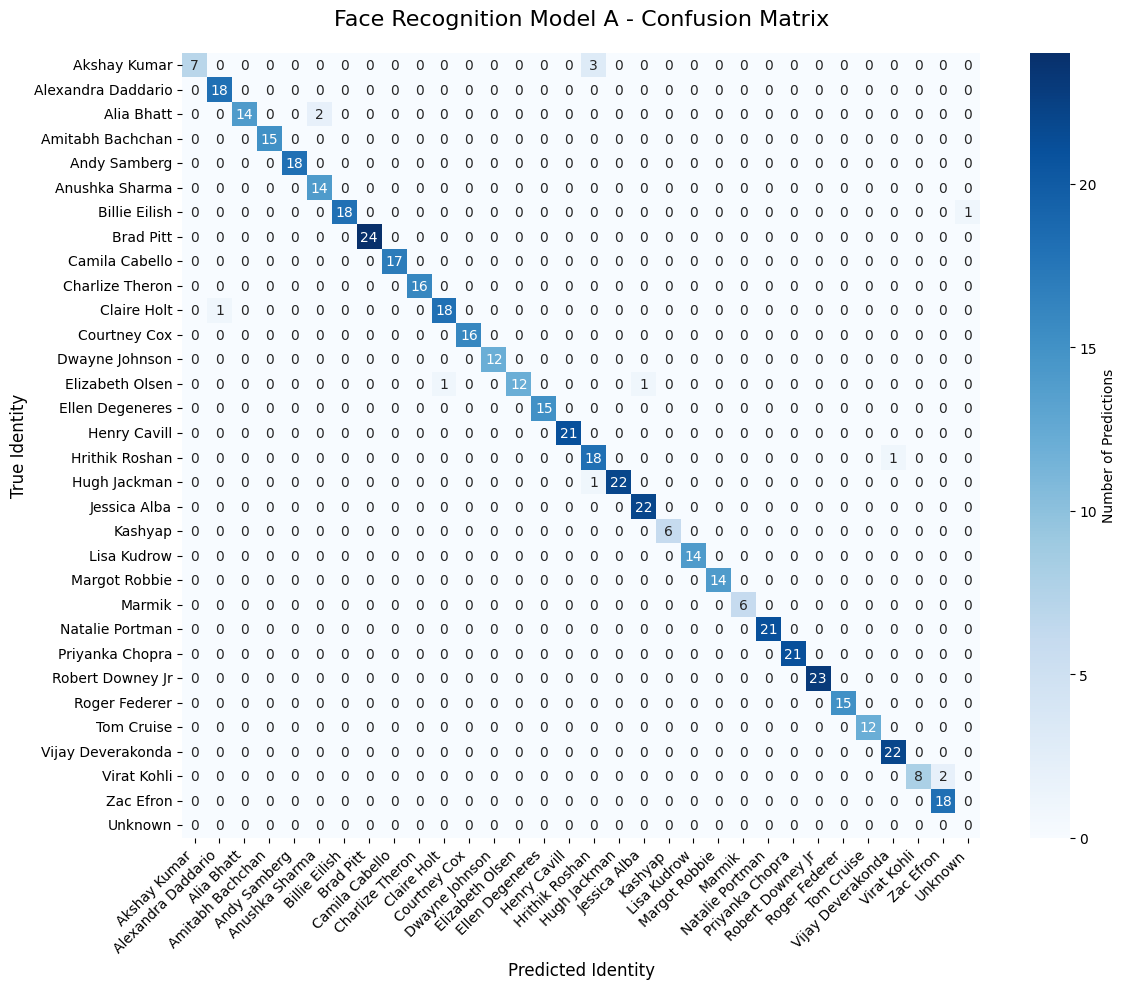


📋 Per-Class Performance Report:
----------------------------------------------------------------------
Class                Precision  Recall     F1-Score   Support   
----------------------------------------------------------------------
Akshay Kumar         1.000      0.700      0.824      10        
Alexandra Daddario   0.947      1.000      0.973      18        
Alia Bhatt           1.000      0.875      0.933      16        
Amitabh Bachchan     1.000      1.000      1.000      15        
Andy Samberg         1.000      1.000      1.000      18        
Anushka Sharma       0.875      1.000      0.933      14        
Billie Eilish        1.000      0.947      0.973      19        
Brad Pitt            1.000      1.000      1.000      24        
Camila Cabello       1.000      1.000      1.000      17        
Charlize Theron      1.000      1.000      1.000      16        
Claire Holt          0.947      0.947      0.947      19        
Courtney Cox         1.000      1.000      1.

In [14]:
# ================================================================================================
# CELL 1: Imports and Setup
# ================================================================================================

import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import face_recognition
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

# ================================================================================================
# CELL 2: Essential Data Preprocessing Functions (Reusable for Deep Learning)
# ================================================================================================

def load_dataset_structure(data_dir):
    """
    Essential preprocessing: Load dataset structure and create mappings
    This function can be reused for any face recognition model (CNN, etc.)
    
    Returns:
        - image_paths: List of all valid image paths
        - labels: List of person names for each image
        - name_to_label: Dictionary mapping names to numeric labels
        - label_to_name: Dictionary mapping numeric labels to names
        - dataset_stats: Basic statistics about the dataset
    """
    print(f"📁 Loading dataset from: {data_dir}")
    
    # Collect all image paths and labels
    image_paths = []
    labels = []
    
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    
    for person_name in sorted(os.listdir(data_dir)):
        person_dir = os.path.join(data_dir, person_name)
        
        if not os.path.isdir(person_dir):
            continue
            
        person_images = []
        for filename in os.listdir(person_dir):
            if filename.lower().endswith(valid_extensions):
                image_path = os.path.join(person_dir, filename)
                person_images.append(image_path)
        
        image_paths.extend(person_images)
        labels.extend([person_name] * len(person_images))
    
    # Create label mappings (essential for any ML model)
    unique_names = sorted(set(labels))
    name_to_label = {name: idx for idx, name in enumerate(unique_names)}
    label_to_name = {idx: name for name, idx in name_to_label.items()}
    numeric_labels = [name_to_label[name] for name in labels]
    
    # Dataset statistics
    label_counts = Counter(labels)
    dataset_stats = {
        'total_images': len(image_paths),
        'total_people': len(unique_names),
        'samples_per_person': label_counts,
        'avg_samples_per_person': np.mean(list(label_counts.values())),
        'min_samples': min(label_counts.values()),
        'max_samples': max(label_counts.values())
    }
    
    print(f"✅ Found {len(image_paths)} images across {len(unique_names)} people")
    
    return image_paths, labels, numeric_labels, name_to_label, label_to_name, dataset_stats

def print_dataset_statistics(dataset_stats, label_to_name):
    """Print comprehensive dataset statistics"""
    print("\n" + "="*50)
    print("📊 DATASET STATISTICS")
    print("="*50)
    
    print(f"Total images: {dataset_stats['total_images']:,}")
    print(f"Total people: {dataset_stats['total_people']}")
    print(f"Average samples per person: {dataset_stats['avg_samples_per_person']:.1f}")
    print(f"Min samples per person: {dataset_stats['min_samples']}")
    print(f"Max samples per person: {dataset_stats['max_samples']}")
    
    print(f"\n📋 Samples per person:")
    for name, count in sorted(dataset_stats['samples_per_person'].items()):
        print(f"  {name}: {count} images")
    
    # Check for imbalanced dataset
    ratio = dataset_stats['max_samples'] / dataset_stats['min_samples']
    if ratio > 3:
        print(f"\n⚠️  Dataset is imbalanced (ratio: {ratio:.1f}:1)")
    else:
        print(f"\n✅ Dataset is reasonably balanced")

def create_train_test_split(image_paths, numeric_labels, test_size=0.2, random_state=42):
    """
    Create stratified train-test split (reusable for any model)
    Ensures each person appears in both train and test sets
    """
    print(f"\n🔄 Creating train-test split ({int((1-test_size)*100)}% train, {int(test_size*100)}% test)")
    
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, numeric_labels,
        test_size=test_size,
        stratify=numeric_labels,
        random_state=random_state
    )
    
    print(f"✅ Train set: {len(train_paths)} images")
    print(f"✅ Test set: {len(test_paths)} images")
    
    return train_paths, test_paths, train_labels, test_labels

# ================================================================================================
# CELL 3: Load and Preprocess Dataset
# ================================================================================================

# Configuration
DATA_DIR = "/kaggle/input/face-recognition-dataset/Original Images/Original Images"

# Load dataset structure
image_paths, labels, numeric_labels, name_to_label, label_to_name, dataset_stats = load_dataset_structure(DATA_DIR)

# Print statistics
print_dataset_statistics(dataset_stats, label_to_name)

# Create train-test split
train_paths, test_paths, train_labels, test_labels = create_train_test_split(
    image_paths, numeric_labels, test_size=0.2, random_state=42
)

# Store preprocessing results for later use
preprocessing_data = {
    'train_paths': train_paths,
    'test_paths': test_paths,
    'train_labels': train_labels,
    'test_labels': test_labels,
    'name_to_label': name_to_label,
    'label_to_name': label_to_name,
    'dataset_stats': dataset_stats
}

print(f"\n💾 Preprocessing complete! Data ready for any face recognition model.")

# ================================================================================================
# CELL 4: Face Recognition Model A - Encoding Functions
# ================================================================================================

def encode_faces(image_paths, labels, model_type="cnn", batch_size=50):
    """
    Encode faces using face_recognition library
    
    Args:
        image_paths: List of image file paths
        labels: Corresponding labels for each image
        model_type: "hog" (CPU-friendly) or "cnn" (GPU, more accurate)
        batch_size: Number of images to process before showing progress
    
    Returns:
        encodings, valid_paths, valid_labels (only for successfully encoded faces)
    """
    print(f"\n🔍 Encoding faces using {model_type.upper()} model...")
    print(f"This may take a while for {len(image_paths)} images...")
    
    encodings = []
    valid_paths = []
    valid_labels = []
    failed_count = 0
    
    start_time = time.time()
    
    for i, (path, label) in enumerate(zip(image_paths, labels)):
        # Progress tracking
        if i % batch_size == 0 and i > 0:
            elapsed = time.time() - start_time
            rate = i / elapsed
            eta = (len(image_paths) - i) / rate if rate > 0 else 0
            print(f"  Progress: {i}/{len(image_paths)} ({i/len(image_paths)*100:.1f}%) - ETA: {eta/60:.1f} min")
        
        try:
            # Load and encode image
            image = face_recognition.load_image_file(path)
            face_encodings = face_recognition.face_encodings(image, model=model_type)
            
            if face_encodings:
                # Take the first (usually largest) face found
                encodings.append(face_encodings[0])
                valid_paths.append(path)
                valid_labels.append(label)
            else:
                failed_count += 1
                
        except Exception as e:
            failed_count += 1
            if failed_count <= 5:  # Show first few errors
                print(f"    ⚠️ Failed to encode {os.path.basename(path)}: {str(e)}")
    
    total_time = time.time() - start_time
    success_rate = len(encodings) / len(image_paths)
    
    print(f"\n✅ Encoding complete!")
    print(f"   Successfully encoded: {len(encodings)} faces")
    print(f"   Failed to encode: {failed_count} images")
    print(f"   Success rate: {success_rate:.1%}")
    print(f"   Total time: {total_time/60:.1f} minutes")
    print(f"   Processing rate: {len(image_paths)/total_time:.1f} images/second")
    
    return encodings, valid_paths, valid_labels

# Encode training and test sets
print("🚀 Starting face encoding process...")

# Encode training set
train_encodings, train_encoded_paths, train_encoded_labels = encode_faces(
    train_paths, train_labels, model_type="cnn"
)

# Encode test set  
test_encodings, test_encoded_paths, test_encoded_labels = encode_faces(
    test_paths, test_labels, model_type="cnn"
)

print(f"\n📈 Final encoding summary:")
print(f"   Training encodings: {len(train_encodings)}")
print(f"   Test encodings: {len(test_encodings)}")

# ================================================================================================
# CELL 5: Face Recognition Model A - Training and Self-Check
# ================================================================================================

class FaceRecognitionModelA:
    """Simple face recognition model using face_recognition library"""
    
    def __init__(self, tolerance=0.6):
        self.tolerance = tolerance
        self.known_encodings = []
        self.known_labels = []
        self.label_to_name = {}
        self.is_trained = False
    
    def train(self, encodings, labels, label_to_name_dict):
        """Train the model with face encodings"""
        self.known_encodings = encodings
        self.known_labels = labels
        self.label_to_name = label_to_name_dict
        self.is_trained = True
        print(f"✅ Model trained with {len(encodings)} face encodings")
    
    def predict(self, face_encoding):
        """Predict identity of a face encoding"""
        if not self.is_trained:
            raise ValueError("Model must be trained first!")
        
        # Compare against all known faces
        matches = face_recognition.compare_faces(
            self.known_encodings, face_encoding, tolerance=self.tolerance
        )
        
        if True in matches:
            # Get first match
            match_index = matches.index(True)
            predicted_label = self.known_labels[match_index]
            predicted_name = self.label_to_name[predicted_label]
            
            # Calculate confidence (1 - face_distance)
            distances = face_recognition.face_distance(self.known_encodings, face_encoding)
            confidence = 1 - distances[match_index]
            
            return predicted_name, confidence, predicted_label
        else:
            return "Unknown", 0.0, -1
    
    def predict_batch(self, face_encodings):
        """Predict identities for multiple face encodings"""
        predictions = []
        confidences = []
        labels = []
        
        for encoding in face_encodings:
            name, conf, label = self.predict(encoding)
            predictions.append(name)
            confidences.append(conf)
            labels.append(label)
        
        return predictions, confidences, labels

# Initialize and train Model A
print("🤖 Initializing Face Recognition Model A")
model_a = FaceRecognitionModelA(tolerance=0.6)
model_a.train(train_encodings, train_encoded_labels, label_to_name)

# ================================================================================================
# CELL 6: Self-Recognition Test
# ================================================================================================

def perform_self_recognition_test(model, encodings, labels):
    """Test if the model can recognize its own training images"""
    print("\n🔍 Performing self-recognition test...")
    print("Each training image should recognize itself correctly")
    
    start_time = time.time()
    correct = 0
    total = len(encodings)
    
    for i, (encoding, true_label) in enumerate(zip(encodings, labels)):
        _, _, predicted_label = model.predict(encoding)
        if predicted_label == true_label:
            correct += 1
    
    accuracy = correct / total
    test_time = time.time() - start_time
    
    print(f"\n📊 Self-recognition results:")
    print(f"   Accuracy: {accuracy:.1%} ({correct}/{total})")
    print(f"   Test time: {test_time:.2f} seconds")
    print(f"   Processing rate: {total/test_time:.1f} faces/second")
    
    if accuracy >= 0.95:
        print("   ✅ PASSED - High self-recognition accuracy")
    else:
        print("   ⚠️  WARNING - Low self-recognition accuracy")
        print("   Consider adjusting tolerance or checking data quality")
    
    return accuracy

# Perform self-recognition test
self_recognition_accuracy = perform_self_recognition_test(
    model_a, train_encodings, train_encoded_labels
)

# ================================================================================================
# CELL 7: Model Evaluation on Test Set
# ================================================================================================

def evaluate_model(model, test_encodings, test_labels, label_to_name):
    """Comprehensive model evaluation"""
    print("\n🎯 Evaluating Model A on test set...")
    
    start_time = time.time()
    
    # Make predictions
    predicted_names, confidences, predicted_labels = model.predict_batch(test_encodings)
    
    eval_time = time.time() - start_time
    
    # Calculate metrics
    correct_predictions = sum(1 for true, pred in zip(test_labels, predicted_labels) 
                            if true == pred)
    accuracy = correct_predictions / len(test_labels)
    
    # Count unknown predictions
    unknown_count = sum(1 for label in predicted_labels if label == -1)
    unknown_rate = unknown_count / len(test_labels)
    
    # Calculate average confidence (excluding unknown)
    valid_confidences = [c for c in confidences if c > 0]
    avg_confidence = np.mean(valid_confidences) if valid_confidences else 0
    
    # Print results
    print(f"\n📈 Test Results:")
    print(f"   Overall Accuracy: {accuracy:.1%} ({correct_predictions}/{len(test_labels)})")
    print(f"   Unknown Predictions: {unknown_count}/{len(test_labels)} ({unknown_rate:.1%})")
    print(f"   Average Confidence: {avg_confidence:.3f}")
    print(f"   Processing Speed: {len(test_encodings)/eval_time:.1f} faces/second")
    print(f"   Total Evaluation Time: {eval_time:.2f} seconds")
    
    return predicted_names, predicted_labels, confidences, accuracy

# Evaluate the model
predicted_names, predicted_labels, confidences, test_accuracy = evaluate_model(
    model_a, test_encodings, test_encoded_labels, label_to_name
)

# ================================================================================================
# CELL 8: Detailed Analysis and Confusion Matrix
# ================================================================================================

def create_confusion_matrix(true_labels, predicted_labels, label_to_name):
    """Create and plot confusion matrix"""
    
    # Create extended labels (including unknown)
    all_labels = list(label_to_name.keys()) + [-1]
    all_names = list(label_to_name.values()) + ["Unknown"]
    
    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=all_labels)
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=all_names, yticklabels=all_names,
               cbar_kws={'label': 'Number of Predictions'})
    
    plt.title('Face Recognition Model A - Confusion Matrix', fontsize=16, pad=20)
    plt.xlabel('Predicted Identity', fontsize=12)
    plt.ylabel('True Identity', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return cm

def generate_classification_report(true_labels, predicted_labels, label_to_name):
    """Generate detailed per-class metrics"""
    print("\n📋 Per-Class Performance Report:")
    print("-" * 70)
    print(f"{'Class':<20} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("-" * 70)
    
    class_metrics = []
    
    for label, name in label_to_name.items():
        # Calculate TP, FP, FN
        tp = sum(1 for t, p in zip(true_labels, predicted_labels) 
                if t == label and p == label)
        fp = sum(1 for t, p in zip(true_labels, predicted_labels) 
                if t != label and p == label)
        fn = sum(1 for t, p in zip(true_labels, predicted_labels) 
                if t == label and p != label)
        
        support = sum(1 for t in true_labels if t == label)
        
        # Calculate metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"{name:<20} {precision:<10.3f} {recall:<10.3f} {f1:<10.3f} {support:<10}")
        
        class_metrics.append({
            'name': name,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'support': support
        })
    
    # Calculate macro averages
    avg_precision = np.mean([m['precision'] for m in class_metrics])
    avg_recall = np.mean([m['recall'] for m in class_metrics])
    avg_f1 = np.mean([m['f1'] for m in class_metrics])
    
    print("-" * 70)
    print(f"{'Macro Average':<20} {avg_precision:<10.3f} {avg_recall:<10.3f} {avg_f1:<10.3f}")
    
    return class_metrics

# Generate confusion matrix
confusion_matrix_data = create_confusion_matrix(test_encoded_labels, predicted_labels, label_to_name)

# Generate classification report
class_performance = generate_classification_report(test_encoded_labels, predicted_labels, label_to_name)

# ================================================================================================
# CELL 9: Sample Predictions Visualization
# ================================================================================================

def show_sample_predictions(model, test_encodings, test_labels, test_paths, label_to_name, n_samples=6):
    """Show sample predictions with images"""
    print(f"\n🖼️ Sample Predictions (showing {n_samples} examples):")
    
    # Select random samples
    sample_indices = np.random.choice(len(test_encodings), min(n_samples, len(test_encodings)), replace=False)
    
    # Create subplot grid
    cols = 3
    rows = (n_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1:
        axes = [axes] if n_samples == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, idx in enumerate(sample_indices):
        if i >= len(axes):
            break
            
        # Get prediction
        true_label = test_labels[idx]
        true_name = label_to_name[true_label]
        pred_name, confidence, pred_label = model.predict(test_encodings[idx])
        
        # Load and display image
        try:
            image = face_recognition.load_image_file(test_paths[idx])
            axes[i].imshow(image)
            axes[i].axis('off')
            
            # Set title with prediction results
            color = 'green' if pred_name == true_name else 'red'
            title = f"True: {true_name}\nPred: {pred_name}\nConf: {confidence:.3f}"
            axes[i].set_title(title, color=color, fontsize=10, pad=10)
            
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error loading\n{os.path.basename(test_paths[idx])}", 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
    
    # Hide empty subplots
    for i in range(len(sample_indices), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show sample predict

## OpenCV + ResNet-50 + MLP


==== DATASET STATS ====
Total Images: 2562
Total People: 31
Avg Samples Per Person: 82.64516129032258
Min Samples: 30
Max Samples: 120
Train images: 1844  |  Val images: 205  |  Test images: 513
Using device: cuda
Epoch 01/15 | Train Loss: 3.0874 | Val Loss: 2.1428 | Val Acc: 41.95% | 31.3s
✅ Saved new best model
Epoch 02/15 | Train Loss: 1.6523 | Val Loss: 1.1464 | Val Acc: 64.88% | 30.3s
✅ Saved new best model
Epoch 03/15 | Train Loss: 0.7608 | Val Loss: 0.7925 | Val Acc: 78.05% | 31.2s
✅ Saved new best model
Epoch 04/15 | Train Loss: 0.3849 | Val Loss: 0.6300 | Val Acc: 81.46% | 31.1s
✅ Saved new best model
Epoch 05/15 | Train Loss: 0.2055 | Val Loss: 0.4528 | Val Acc: 88.78% | 30.5s
✅ Saved new best model
Epoch 06/15 | Train Loss: 0.1165 | Val Loss: 0.4590 | Val Acc: 85.85% | 30.7s
Epoch 07/15 | Train Loss: 0.0827 | Val Loss: 0.4394 | Val Acc: 85.85% | 30.3s
Epoch 08/15 | Train Loss: 0.0616 | Val Loss: 0.4902 | Val Acc: 84.39% | 30.7s
Epoch 09/15 | Train Loss: 0.0504 | Val Loss: 0

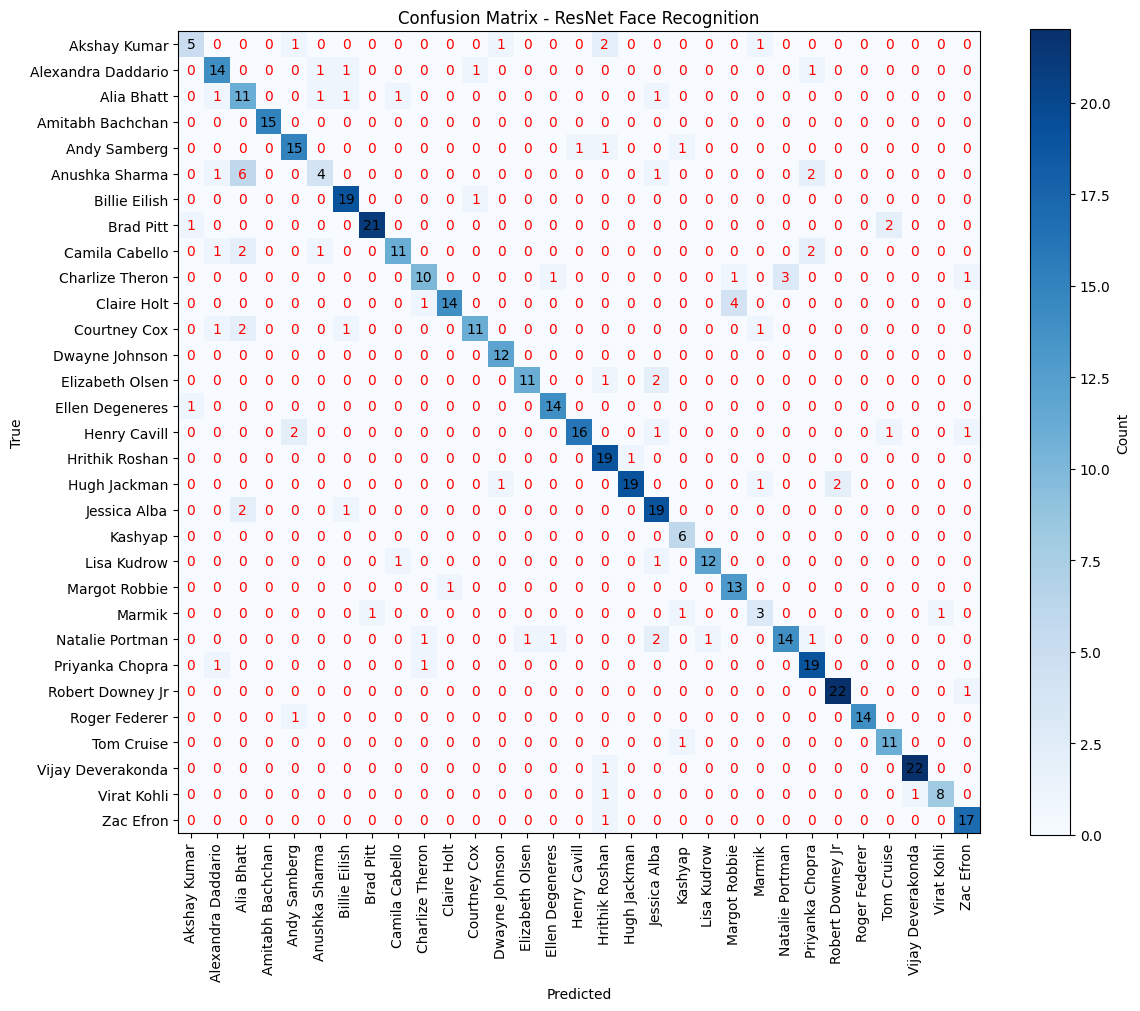


Detailed Classification Report:
                    precision    recall  f1-score   support

      Akshay Kumar       0.71      0.50      0.59        10
Alexandra Daddario       0.74      0.78      0.76        18
        Alia Bhatt       0.48      0.69      0.56        16
  Amitabh Bachchan       1.00      1.00      1.00        15
      Andy Samberg       0.79      0.83      0.81        18
    Anushka Sharma       0.57      0.29      0.38        14
     Billie Eilish       0.83      0.95      0.88        20
         Brad Pitt       0.95      0.88      0.91        24
    Camila Cabello       0.85      0.65      0.73        17
   Charlize Theron       0.77      0.62      0.69        16
       Claire Holt       0.93      0.74      0.82        19
      Courtney Cox       0.85      0.69      0.76        16
    Dwayne Johnson       0.86      1.00      0.92        12
   Elizabeth Olsen       0.92      0.79      0.85        14
   Ellen Degeneres       0.88      0.93      0.90        15
      

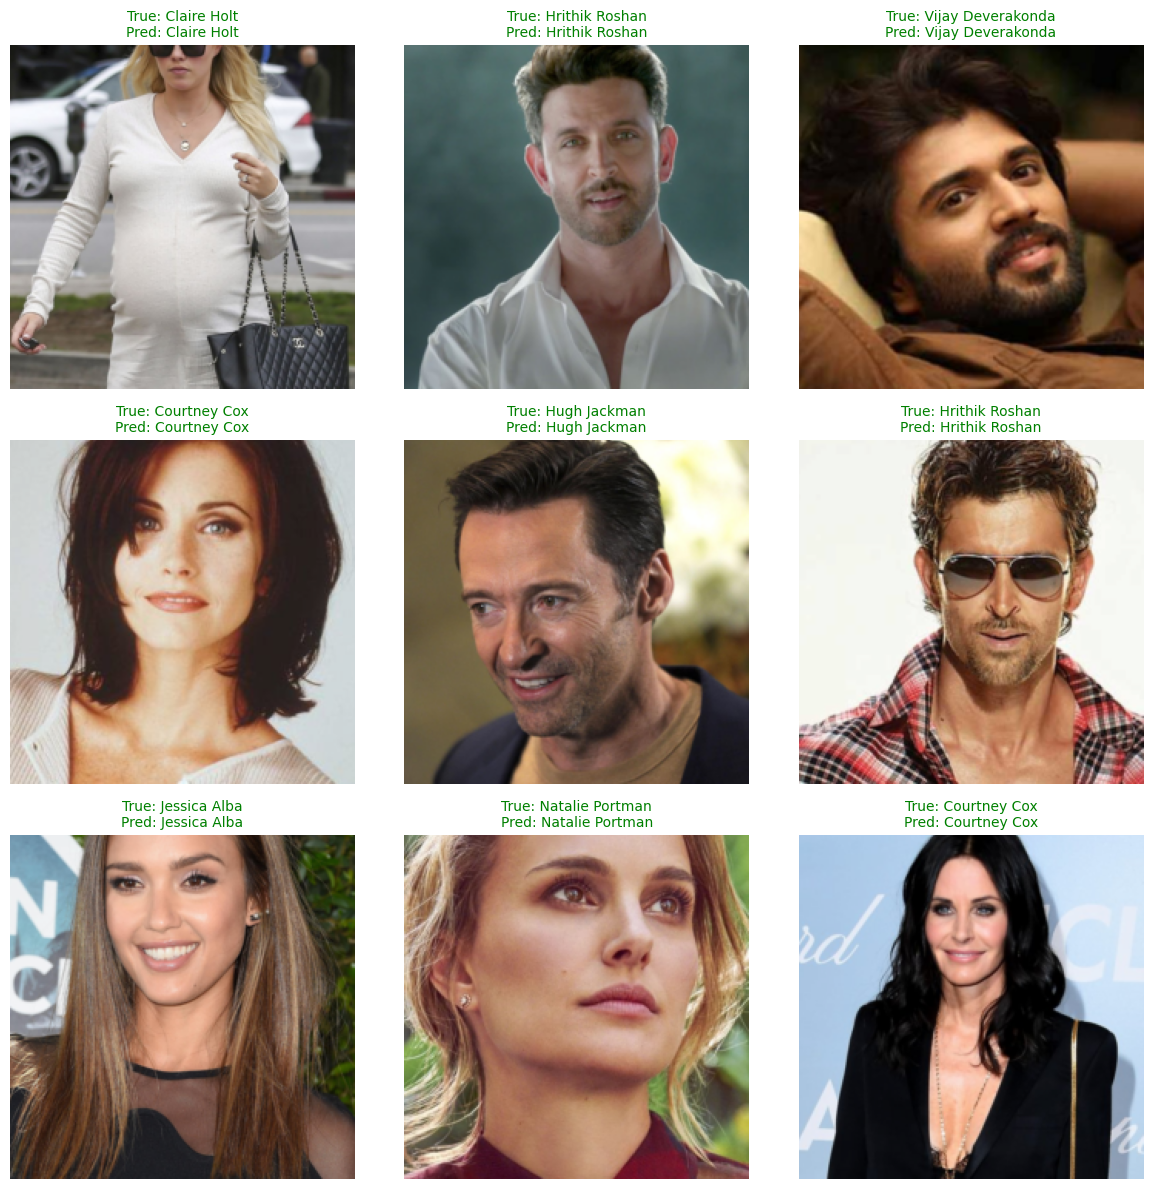


🎉 All done! Adjust architecture, hyperparameters, and augmentation as desired.


In [7]:
# ================================================================================================
# Face Recognition with ResNet (Deep Learning Pipeline)
# ================================================================================================
# Author: ChatGPT (OpenAI)
# Description: End‑to‑end face recognition script that mirrors the classical pipeline you provided
#              but swaps the hand‑crafted encodings for a trainable ResNet‑based classifier.
#              Designed to run on Kaggle / Colab GPUs, yet still works on CPU (slowly).
#
# Major Steps
# 1. Imports & Global Config
# 2. Dataset Discovery & Statistics (re‑uses functions you had)
# 3. Custom PyTorch Dataset that consumes the (path, label) lists
# 4. DataLoaders with augmentation
# 5. Model Definition (pre‑trained ResNet‑50 with new classifier head)
# 6. Training / Validation Loop with live metrics
# 7. Final Evaluation on held‑out test set (accuracy, confusion matrix, per‑class PRF1)
# 8. Sample Prediction Visualization
#
# You can freely tweak depth (ResNet18/34/50/101), batch size, epochs, and optimiser.
# ================================================================================================

# =========================================================
# 1. Imports & Global Config
# =========================================================
import os
import time
from collections import Counter
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

# Re‑use your existing helper for dataset traversal
# (paste your original load_dataset_structure & print_dataset_statistics if needed)
from pathlib import Path

# =========================================================
# 2. Re‑usable Dataset Traversal (copied & slightly trimmed)
# =========================================================

def load_dataset_structure(data_dir: str):
    """Walk directory tree, return image paths, numeric labels, mappings, stats."""
    valid_ext = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}
    image_paths: List[str] = []
    labels: List[str] = []

    for person_name in sorted(os.listdir(data_dir)):
        person_path = os.path.join(data_dir, person_name)
        if not os.path.isdir(person_path):
            continue
        for fname in os.listdir(person_path):
            if Path(fname).suffix.lower() in valid_ext:
                image_paths.append(os.path.join(person_path, fname))
                labels.append(person_name)

    unique_names = sorted(set(labels))
    name_to_label = {n: i for i, n in enumerate(unique_names)}
    label_to_name = {i: n for n, i in name_to_label.items()}
    numeric_labels = [name_to_label[n] for n in labels]

    c = Counter(labels)
    stats = {
        "total_images": len(image_paths),
        "total_people": len(unique_names),
        "samples_per_person": c,
        "avg_samples_per_person": float(np.mean(list(c.values()))),
        "min_samples": int(min(c.values())),
        "max_samples": int(max(c.values())),
    }
    return image_paths, numeric_labels, name_to_label, label_to_name, stats


def print_dataset_statistics(stats):
    print("\n==== DATASET STATS ====")
    for k, v in stats.items():
        if k == "samples_per_person":
            continue
        print(f"{k.replace('_', ' ').title()}: {v}")

# =========================================================
# 3. Custom PyTorch Dataset
# =========================================================
class FaceDataset(Dataset):
    """Simple dataset that loads images from a list of paths."""

    def __init__(self, image_paths: List[str], labels: List[int], transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# =========================================================
# 4. Paths, Splits & Dataloaders
# =========================================================
DATA_DIR = "/kaggle/input/face-recognition-dataset/Original Images/Original Images"  # adjust if needed
TEST_SIZE = 0.2
VAL_SIZE = 0.1  # portion of TRAIN that becomes VAL
BATCH_SIZE = 32
NUM_WORKERS = 4

# Discover dataset
image_paths, numeric_labels, name_to_label, label_to_name, stats = load_dataset_structure(DATA_DIR)
print_dataset_statistics(stats)

# Stratified train/test
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths,
    numeric_labels,
    test_size=TEST_SIZE,
    stratify=numeric_labels,
    random_state=42,
)

# Further split train into train/val
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths,
    train_labels,
    test_size=VAL_SIZE,
    stratify=train_labels,
    random_state=42,
)

print(f"Train images: {len(train_paths)}  |  Val images: {len(val_paths)}  |  Test images: {len(test_paths)}")

# ImageNet‑style mean/std for normalisation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

dls = {
    "train": DataLoader(FaceDataset(train_paths, train_labels, transform=train_tfms),
                         batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True),
    "val": DataLoader(FaceDataset(val_paths, val_labels, transform=val_tfms),
                       batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True),
    "test": DataLoader(FaceDataset(test_paths, test_labels, transform=val_tfms),
                        batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True),
}

# =========================================================
# 5. Model Definition
# =========================================================
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", dev)

num_classes = len(label_to_name)
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(dev)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)

# =========================================================
# 6. Training Loop
# =========================================================
EPOCHS = 15
best_val_acc = 0.0
train_history = {"epoch": [], "train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    for images, labels in dls["train"]:
        images, labels = images.to(dev), labels.to(dev)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    train_loss = running_loss / len(dls["train"].dataset)

    # ---------- Validation ----------
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in dls["val"]:
            images, labels = images.to(dev), labels.to(dev)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    val_loss /= len(dls["val"].dataset)
    val_acc = correct / len(dls["val"].dataset)
    scheduler.step(val_loss)

    train_history["epoch"].append(epoch)
    train_history["train_loss"].append(train_loss)
    train_history["val_loss"].append(val_loss)
    train_history["val_acc"].append(val_acc)

    elapsed = time.time() - epoch_start
    print(f"Epoch {epoch:02}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2%} | {elapsed:.1f}s")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet_face_recognizer.pth")
        print("✅ Saved new best model")

# =========================================================
# 7. Evaluation on Test Set
# =========================================================
print("\nLoading best model for evaluation…")
model.load_state_dict(torch.load("best_resnet_face_recognizer.pth", map_location=dev))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in dls["test"]:
        images = images.to(dev)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Accuracy
correct_test = sum(p == t for p, t in zip(all_preds, all_labels))
test_acc = correct_test / len(all_labels)
print(f"Test Accuracy: {test_acc:.2%} ({correct_test}/{len(all_labels)})")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(12,10))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix - ResNet Face Recognition")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar(label="Count")
plt.xticks(ticks=np.arange(num_classes), labels=[label_to_name[i] for i in range(num_classes)], rotation=90)
plt.yticks(ticks=np.arange(num_classes), labels=[label_to_name[i] for i in range(num_classes)])
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="red" if i != j else "black")
plt.tight_layout()
plt.show()

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[label_to_name[i] for i in range(num_classes)]))

# =========================================================
# 8. Sample Predictions Visualisation
# =========================================================
import random

def imshow_tensor(img_tensor):
    """Denormalise and show an image tensor (C,H,W)."""
    img = img_tensor.numpy().transpose(1, 2, 0)
    img = img * np.array(std) + np.array(mean)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

samples = random.sample(range(len(test_paths)), k=min(9, len(test_paths)))
plt.figure(figsize=(12, 12))
for i, idx in enumerate(samples, 1):
    img = Image.open(test_paths[idx]).convert("RGB")
    x = val_tfms(img).unsqueeze(0).to(dev)
    pred = model(x).argmax(dim=1).item()
    true_label = test_labels[idx]
    plt.subplot(3, 3, i)
    imshow_tensor(val_tfms(img))
    title_color = "green" if pred == true_label else "red"
    plt.title(f"True: {label_to_name[true_label]}\nPred: {label_to_name[pred]}", color=title_color, fontsize=10)
plt.tight_layout()
plt.show()

print("\n🎉 All done! Adjust architecture, hyperparameters, and augmentation as desired.")


## FINAL COMPARISON

In [3]:
# %% [markdown]
# # Face Recognition Model Comparison (Notebook Version)
# Three approaches:
# 1. Model A: `face_recognition` (dlib-based CNN encodings)  
# 2. Model B: ResNet-50 (transfer learning)  
# 3. Model C: Custom CNN from scratch

# %% Imports & Settings
%matplotlib inline
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

# face_recognition
import face_recognition

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Progress bars
from tqdm.notebook import tqdm

print("🚀 Face Recognition Model Comparison Framework")
print("=" * 60)

# %% [markdown]
# ## Shared Dataset Preprocessing

# %% Load dataset structure
def load_dataset_structure(data_dir):
    """Load dataset structure (one folder per person)."""
    print(f"📁 Loading dataset from: {data_dir}")
    image_paths = []
    labels = []
    valid_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

    for person_name in sorted(os.listdir(data_dir)):
        person_dir = os.path.join(data_dir, person_name)
        if not os.path.isdir(person_dir):
            continue
        for filename in os.listdir(person_dir):
            if filename.lower().endswith(valid_ext):
                image_paths.append(os.path.join(person_dir, filename))
                labels.append(person_name)

    unique_names = sorted(set(labels))
    name_to_label = {name: idx for idx, name in enumerate(unique_names)}
    label_to_name = {idx: name for name, idx in name_to_label.items()}
    numeric_labels = [name_to_label[n] for n in labels]

    label_counts = Counter(labels)
    print(f"✅ Dataset loaded: {len(image_paths)} images, {len(unique_names)} people")
    return image_paths, labels, numeric_labels, name_to_label, label_to_name

# %% PyTorch Dataset
class FaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]
        try:
            img = Image.open(path).convert('RGB')
        except Exception:
            img = Image.new('RGB', (224, 224), color=(128, 128, 128))
        if self.transform:
            img = self.transform(img)
        return img, label

# %% [markdown]
# ## Model A: face_recognition Library (dlib-based)

# %% Model A class
class FaceRecognitionModelA:
    def __init__(self, tolerance=0.6, model_type="cnn"):
        self.tolerance = tolerance
        self.model_type = model_type
        self.known_encodings = []
        self.known_labels = []
        self.is_trained = False
        self.training_time = 0
        self.model_size_mb = 0

    def encode_faces(self, image_paths, labels):
        print(f"🔍 Model A: Encoding {len(image_paths)} faces using {self.model_type.upper()}")
        start = time.time()
        encodings = []
        valid_labels = []
        for path, label in tqdm(list(zip(image_paths, labels)), desc="Encoding faces", total=len(image_paths)):
            try:
                img = face_recognition.load_image_file(path)
                face_encs = face_recognition.face_encodings(img, model=self.model_type)
                if face_encs:
                    encodings.append(face_encs[0])
                    valid_labels.append(label)
            except Exception:
                continue
        elapsed = time.time() - start
        print(f"✅ Encoded {len(encodings)}/{len(image_paths)} in {elapsed:.1f}s")
        return encodings, valid_labels

    def train(self, train_paths, train_labels, label_to_name_dict):
        print("\n" + "="*50)
        print("🤖 TRAINING MODEL A (face_recognition)")
        print("="*50)
        t0 = time.time()
        self.known_encodings, self.known_labels = self.encode_faces(train_paths, train_labels)
        self.is_trained = True
        self.model_size_mb = len(self.known_encodings) * 128 * 4 / (1024*1024)
        self.training_time = time.time() - t0
        print(f"✅ Model A trained: {len(self.known_encodings)} encodings in {self.training_time:.1f}s")
        print(f"📊 Model A size: {self.model_size_mb:.2f} MB")

    def predict_batch(self, test_paths, test_labels):
        print("\n🎯 Model A: Testing...")
        t0 = time.time()
        test_encodings, valid_labels = self.encode_faces(test_paths, test_labels)
        preds = []
        confs = []
        for enc in tqdm(test_encodings, desc="Matching faces", total=len(test_encodings)):
            matches = face_recognition.compare_faces(self.known_encodings, enc, tolerance=self.tolerance)
            if True in matches:
                idx = matches.index(True)
                preds.append(self.known_labels[idx])
                dists = face_recognition.face_distance(self.known_encodings, enc)
                confs.append(max(0, 1 - dists[idx]))
            else:
                preds.append(-1)
                confs.append(0.0)
        elapsed = time.time() - t0
        print(f"✅ Model A tested {len(test_encodings)} in {elapsed:.1f}s")
        return valid_labels, preds, confs, elapsed

# %% [markdown]
# ## Model B: ResNet-50 Transfer Learning

# %% Model B class
class ResNetFaceRecognizer:
    def __init__(self, num_classes, device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_classes = num_classes
        self.model = None
        self.training_time = 0
        self.best_val_acc = 0.0
        self.model_size_mb = 0

        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std),
        ])

    def create_model(self):
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        model.fc = nn.Linear(model.fc.in_features, self.num_classes)
        return model.to(self.device)

    def count_parameters(self, model):
        return sum(p.numel() for p in model.parameters())

    def train(self, train_paths, train_labels, val_paths, val_labels, epochs=10, batch_size=32):
        print("\n" + "="*50)
        print("🤖 TRAINING MODEL B (ResNet-50 Transfer Learning)")
        print("="*50)
        t0 = time.time()

        self.model = self.create_model()
        total_params = self.count_parameters(self.model)
        self.model_size_mb = total_params * 4 / (1024*1024)
        print(f"📊 Model parameters: {total_params:,} ({self.model_size_mb:.1f} MB)")

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

        train_ds = FaceDataset(train_paths, train_labels, self.train_transform)
        val_ds = FaceDataset(val_paths, val_labels, self.val_transform)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

        print(f"🚀 Training on {self.device} for {epochs} epochs...")
        for epoch in range(1, epochs + 1):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for imgs, lbls in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
                imgs, lbls = imgs.to(self.device), lbls.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(imgs)
                loss = criterion(outputs, lbls)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += lbls.size(0)
                correct += predicted.eq(lbls).sum().item()

            train_acc = correct / total
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            self.model.eval()
            with torch.no_grad():
                for imgs, lbls in val_loader:
                    imgs, lbls = imgs.to(self.device), lbls.to(self.device)
                    outputs = self.model(imgs)
                    loss_v = criterion(outputs, lbls)
                    val_loss += loss_v.item()
                    _, predicted = outputs.max(1)
                    val_total += lbls.size(0)
                    val_correct += predicted.eq(lbls).sum().item()

            val_acc = val_correct / val_total
            scheduler.step()
            print(f"Epoch {epoch:2}/{epochs} | Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | Loss: {val_loss/len(val_loader):.4f}")
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), "best_resnet_model.pth")

        self.training_time = time.time() - t0
        print(f"✅ Model B trained in {self.training_time:.1f}s (Best Val Acc: {self.best_val_acc:.3f})")

    def predict_batch(self, test_paths, test_labels):
        print("\n🎯 Model B: Testing...")
        t0 = time.time()
        self.model.load_state_dict(torch.load("best_resnet_model.pth", map_location=self.device))
        self.model.eval()

        test_ds = FaceDataset(test_paths, test_labels, self.val_transform)
        test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)
        preds = []
        probs = []
        with torch.no_grad():
            for imgs, _ in tqdm(test_loader, desc="Inference", leave=False):
                imgs = imgs.to(self.device)
                outputs = self.model(imgs)
                p = torch.softmax(outputs, dim=1)
                preds.extend(outputs.argmax(dim=1).cpu().numpy())
                probs.extend(p.max(dim=1)[0].cpu().numpy())

        elapsed = time.time() - t0
        print(f"✅ Model B tested {len(preds)} in {elapsed:.1f}s")
        return test_labels, preds, probs, elapsed

# %% [markdown]
# ## Model C: Custom CNN Architecture

# %% Model C classes
class CustomFaceCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomFaceCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((7, 7))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024 * 7 * 7, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

class CustomFaceRecognizer:
    def __init__(self, num_classes, device=None):
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_classes = num_classes
        self.model = None
        self.training_time = 0
        self.best_val_acc = 0.0
        self.model_size_mb = 0

        self.mean = [0.5, 0.5, 0.5]
        self.std = [0.5, 0.5, 0.5]
        self.train_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std),
        ])

    def count_parameters(self, model):
        return sum(p.numel() for p in model.parameters())

    def train(self, train_paths, train_labels, val_paths, val_labels, epochs=15, batch_size=32):
        print("\n" + "="*50)
        print("🤖 TRAINING MODEL C (Custom CNN)")
        print("="*50)
        t0 = time.time()

        self.model = CustomFaceCNN(self.num_classes).to(self.device)
        total_params = self.count_parameters(self.model)
        self.model_size_mb = total_params * 4 / (1024*1024)
        print(f"📊 Model parameters: {total_params:,} ({self.model_size_mb:.1f} MB)")

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10], gamma=0.1)

        train_ds = FaceDataset(train_paths, train_labels, self.train_transform)
        val_ds = FaceDataset(val_paths, val_labels, self.val_transform)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

        print(f"🚀 Training on {self.device} for {epochs} epochs...")
        for epoch in range(1, epochs + 1):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for imgs, lbls in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False):
                imgs, lbls = imgs.to(self.device), lbls.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(imgs)
                loss = criterion(outputs, lbls)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += lbls.size(0)
                correct += predicted.eq(lbls).sum().item()

            val_loss = 0.0
            val_correct = 0
            val_total = 0
            self.model.eval()
            with torch.no_grad():
                for imgs, lbls in val_loader:
                    imgs, lbls = imgs.to(self.device), lbls.to(self.device)
                    outputs = self.model(imgs)
                    loss_v = criterion(outputs, lbls)
                    val_loss += loss_v.item()
                    _, predicted = outputs.max(1)
                    val_total += lbls.size(0)
                    val_correct += predicted.eq(lbls).sum().item()

            val_acc = val_correct / val_total
            scheduler.step()
            print(f"Epoch {epoch:2}/{epochs} | Val Acc: {val_acc:.3f} | Loss: {val_loss/len(val_loader):.4f}")
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), "best_custom_model.pth")

        self.training_time = time.time() - t0
        print(f"✅ Model C trained in {self.training_time:.1f}s (Best Val Acc: {self.best_val_acc:.3f})")

    def predict_batch(self, test_paths, test_labels):
        print("\n🎯 Model C: Testing...")
        t0 = time.time()
        self.model.load_state_dict(torch.load("best_custom_model.pth", map_location=self.device))
        self.model.eval()

        test_ds = FaceDataset(test_paths, test_labels, self.val_transform)
        test_loader = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)
        preds = []
        probs = []
        with torch.no_grad():
            for imgs, _ in tqdm(test_loader, desc="Inference", leave=False):
                imgs = imgs.to(self.device)
                outputs = self.model(imgs)
                p = torch.softmax(outputs, dim=1)
                preds.extend(outputs.argmax(dim=1).cpu().numpy())
                probs.extend(p.max(dim=1)[0].cpu().numpy())

        elapsed = time.time() - t0
        print(f"✅ Model C tested {len(preds)} in {elapsed:.1f}s")
        return test_labels, preds, probs, elapsed

# %% [markdown]
# ## Evaluation & Comparison Functions

# %% Metrics
def calculate_metrics(true_labels, pred_labels):
    if -1 in pred_labels:
        idxs = [i for i, p in enumerate(pred_labels) if p != -1]
        if not idxs:
            return {"accuracy": 0, "precision": 0, "recall": 0, "f1": 0}
        true_labels = [true_labels[i] for i in idxs]
        pred_labels = [pred_labels[i] for i in idxs]

    acc = accuracy_score(true_labels, pred_labels)
    prec, rec, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='macro', zero_division=0
    )
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# %% Visualization
def create_comparison_visualization(results_df):
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Face Recognition Models Comparison', fontsize=16, fontweight='bold')

    models = results_df.index
    colors = ['#3498db', '#e74c3c', '#2ecc71']

    # Accuracy
    ax1 = axes[0, 0]
    bars1 = ax1.bar(models, results_df['Accuracy (%)'], color=colors, alpha=0.7)
    ax1.set_title('Accuracy Comparison', fontweight='bold')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_ylim(0, 100)
    for bar in bars1:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., h + 1, f'{h:.1f}%', ha='center', va='bottom', fontweight='bold')

    # F1-Score
    ax2 = axes[0, 1]
    bars2 = ax2.bar(models, results_df['F1-Score (%)'], color=colors, alpha=0.7)
    ax2.set_title('F1-Score Comparison', fontweight='bold')
    ax2.set_ylabel('F1-Score (%)')
    ax2.set_ylim(0, 100)
    for bar in bars2:
        h = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., h + 1, f'{h:.1f}%', ha='center', va='bottom', fontweight='bold')

    # Training Time
    ax3 = axes[1, 0]
    bars3 = ax3.bar(models, results_df['Training Time (s)'], color=colors, alpha=0.7)
    ax3.set_title('Training Time Comparison', fontweight='bold')
    ax3.set_ylabel('Seconds')
    for bar in bars3:
        h = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., h + h * 0.05, f'{h:.0f}s', ha='center', va='bottom', fontweight='bold')

    # Inference Speed
    ax4 = axes[1, 1]
    bars4 = ax4.bar(models, results_df['Inference Speed (faces/s)'], color=colors, alpha=0.7)
    ax4.set_title('Inference Speed Comparison', fontweight='bold')
    ax4.set_ylabel('Faces per Second')
    for bar in bars4:
        h = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., h + h * 0.05, f'{h:.1f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Radar chart
    from math import pi
    metrics = ['Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1-Score (%)']
    N = len(metrics)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    for i, model in enumerate(results_df.index):
        values = [results_df.loc[model, m] for m in metrics]
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 100)
    ax.set_title('Model Performance Radar Chart', size=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.grid(True)
    plt.show()

🚀 Face Recognition Model Comparison Framework


📁 Loading dataset from: /kaggle/input/face-recognition-dataset/Original Images/Original Images
✅ Dataset loaded: 2562 images, 31 people

🤖 TRAINING MODEL A (face_recognition)
🔍 Model A: Encoding 2049 faces using CNN


Encoding faces:   0%|          | 0/2049 [00:00<?, ?it/s]

✅ Encoded 2034/2049 in 1939.9s
✅ Model A trained: 2034 encodings in 1939.9s
📊 Model A size: 0.99 MB

🎯 Model A: Testing...
🔍 Model A: Encoding 257 faces using CNN


Encoding faces:   0%|          | 0/257 [00:00<?, ?it/s]

✅ Encoded 255/257 in 216.3s


Matching faces:   0%|          | 0/255 [00:00<?, ?it/s]

✅ Model A tested 255 in 217.3s

🤖 TRAINING MODEL B (ResNet-50 Transfer Learning)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s] 


📊 Model parameters: 23,571,551 (89.9 MB)
🚀 Training on cuda for 10 epochs...


Epoch 1/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  1/10 | Train Acc: 0.279 | Val Acc: 0.578 | Loss: 1.8514


Epoch 2/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  2/10 | Train Acc: 0.668 | Val Acc: 0.695 | Loss: 1.1891


Epoch 3/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  3/10 | Train Acc: 0.861 | Val Acc: 0.785 | Loss: 0.8205


Epoch 4/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  4/10 | Train Acc: 0.941 | Val Acc: 0.801 | Loss: 0.6859


Epoch 5/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  5/10 | Train Acc: 0.961 | Val Acc: 0.828 | Loss: 0.5665


Epoch 6/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  6/10 | Train Acc: 0.983 | Val Acc: 0.848 | Loss: 0.4702


Epoch 7/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  7/10 | Train Acc: 0.992 | Val Acc: 0.855 | Loss: 0.4794


Epoch 8/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  8/10 | Train Acc: 0.995 | Val Acc: 0.848 | Loss: 0.4325


Epoch 9/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  9/10 | Train Acc: 0.995 | Val Acc: 0.875 | Loss: 0.4291


Epoch 10/10:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 10/10 | Train Acc: 0.998 | Val Acc: 0.855 | Loss: 0.4790
✅ Model B trained in 834.5s (Best Val Acc: 0.875)

🎯 Model B: Testing...


Inference:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Model B tested 257 in 6.7s

🤖 TRAINING MODEL C (Custom CNN)
📊 Model parameters: 113,192,223 (431.8 MB)
🚀 Training on cuda for 15 epochs...


Epoch 1/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  1/15 | Val Acc: 0.070 | Loss: 3.3490


Epoch 2/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  2/15 | Val Acc: 0.102 | Loss: 3.2709


Epoch 3/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  3/15 | Val Acc: 0.102 | Loss: 3.2522


Epoch 4/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  4/15 | Val Acc: 0.172 | Loss: 2.8014


Epoch 5/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  5/15 | Val Acc: 0.152 | Loss: 3.0008


Epoch 6/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  6/15 | Val Acc: 0.195 | Loss: 2.4540


Epoch 7/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  7/15 | Val Acc: 0.203 | Loss: 2.4076


Epoch 8/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  8/15 | Val Acc: 0.219 | Loss: 2.3394


Epoch 9/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch  9/15 | Val Acc: 0.219 | Loss: 2.2994


Epoch 10/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 10/15 | Val Acc: 0.246 | Loss: 2.2544


Epoch 11/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 11/15 | Val Acc: 0.258 | Loss: 2.1950


Epoch 12/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 12/15 | Val Acc: 0.262 | Loss: 2.1879


Epoch 13/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 13/15 | Val Acc: 0.246 | Loss: 2.1726


Epoch 14/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 14/15 | Val Acc: 0.270 | Loss: 2.1559


Epoch 15/15:   0%|          | 0/65 [00:00<?, ?it/s]

Epoch 15/15 | Val Acc: 0.238 | Loss: 2.2036
✅ Model C trained in 1021.6s (Best Val Acc: 0.270)

🎯 Model C: Testing...


Inference:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Model C tested 257 in 6.4s


,Accuracy (%),Precision (%),Recall (%),F1-Score (%),Training Time (s),Inference Speed (faces/s)
Model A,97.244094,97.938379,96.196877,96.490520,1939.917121,1.173740
Model B,85.603113,87.290845,85.526230,85.330629,834.453027,38.162536
Model C,27.626459,25.870528,25.900712,24.137089,1021.555728,39.969718


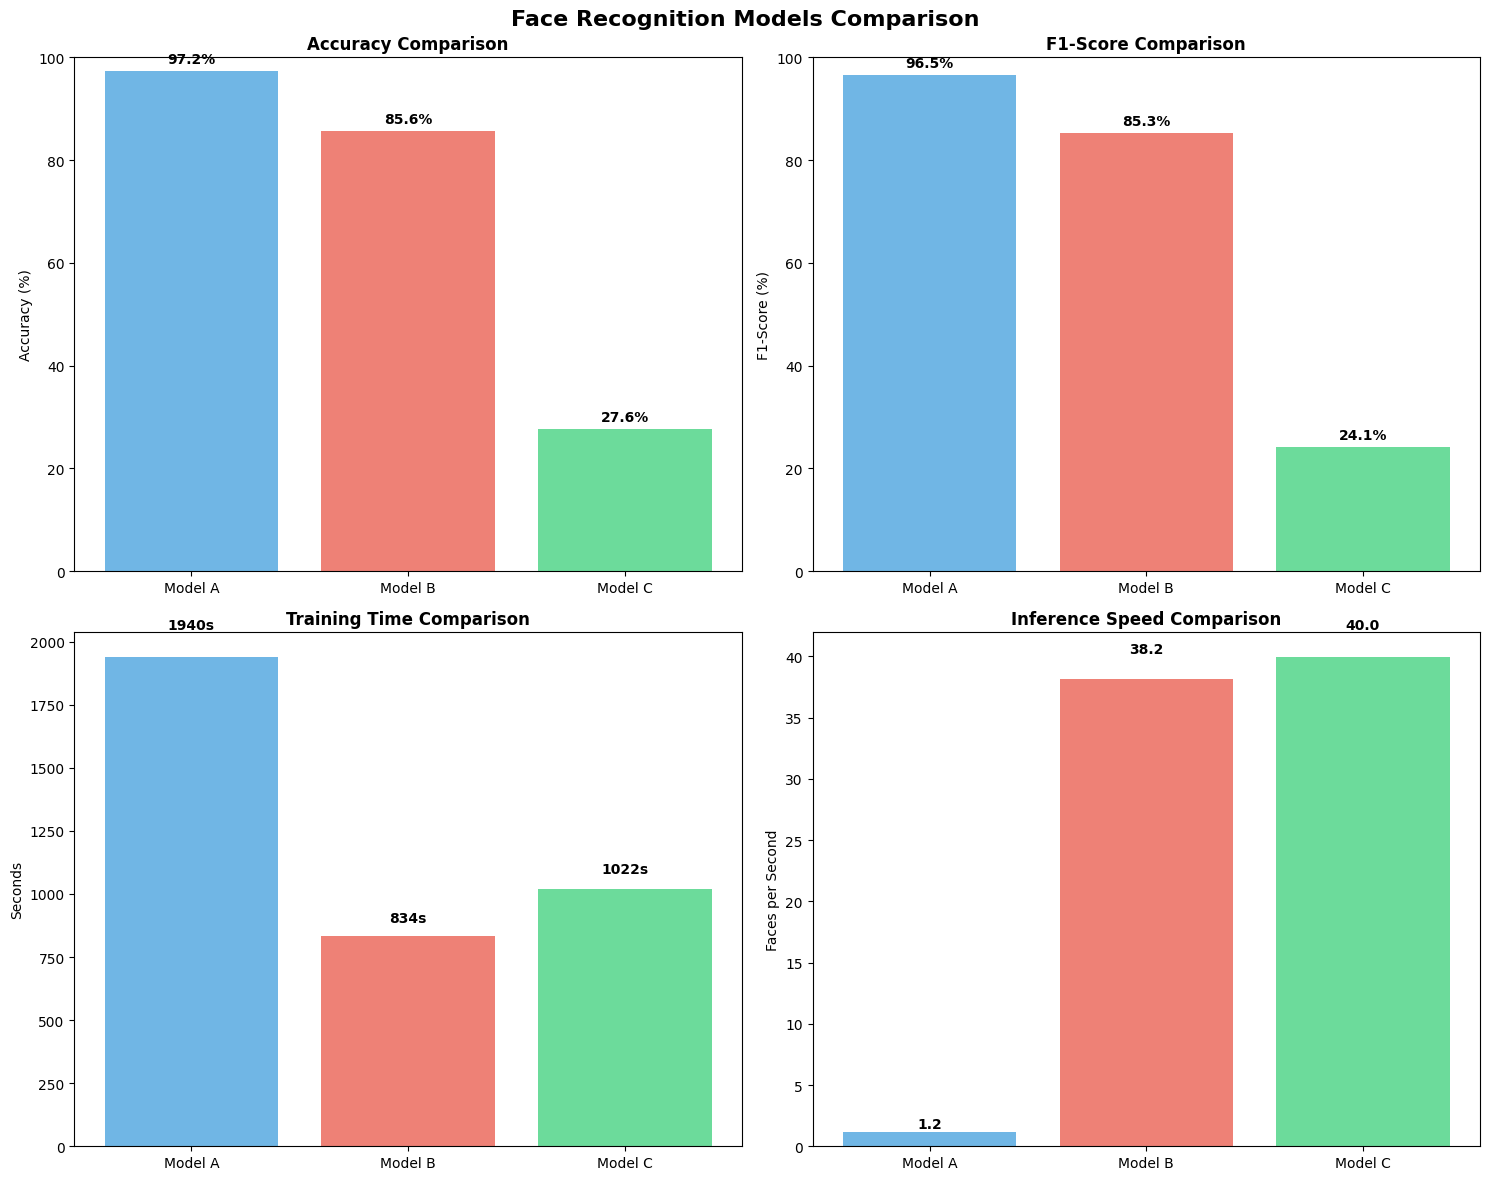

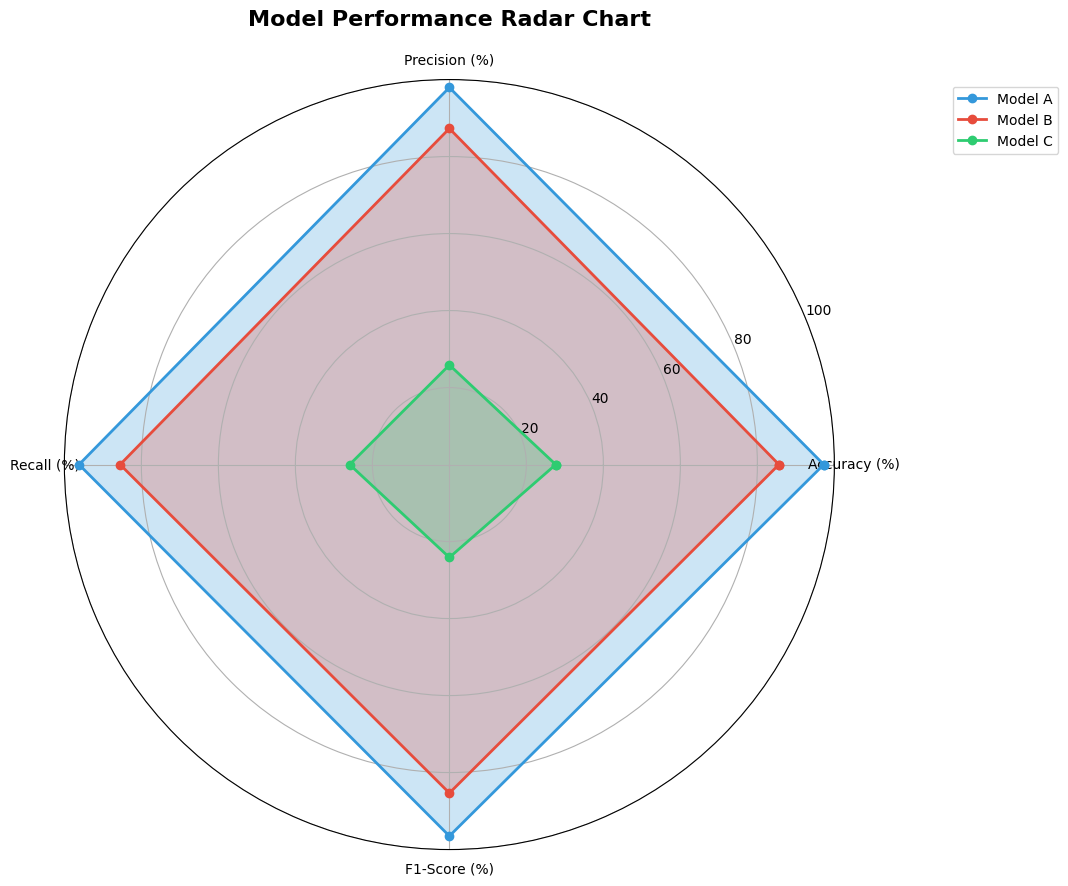

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, idx_to_name, model_name):
    """Plots a confusion matrix with label names."""
    cm = confusion_matrix(y_true, y_pred, labels=list(idx_to_name.keys()))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=[idx_to_name[i] for i in range(len(idx_to_name))],
                yticklabels=[idx_to_name[i] for i in range(len(idx_to_name))])
    plt.title(f"Confusion Matrix - {model_name}", fontsize=16, fontweight='bold')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


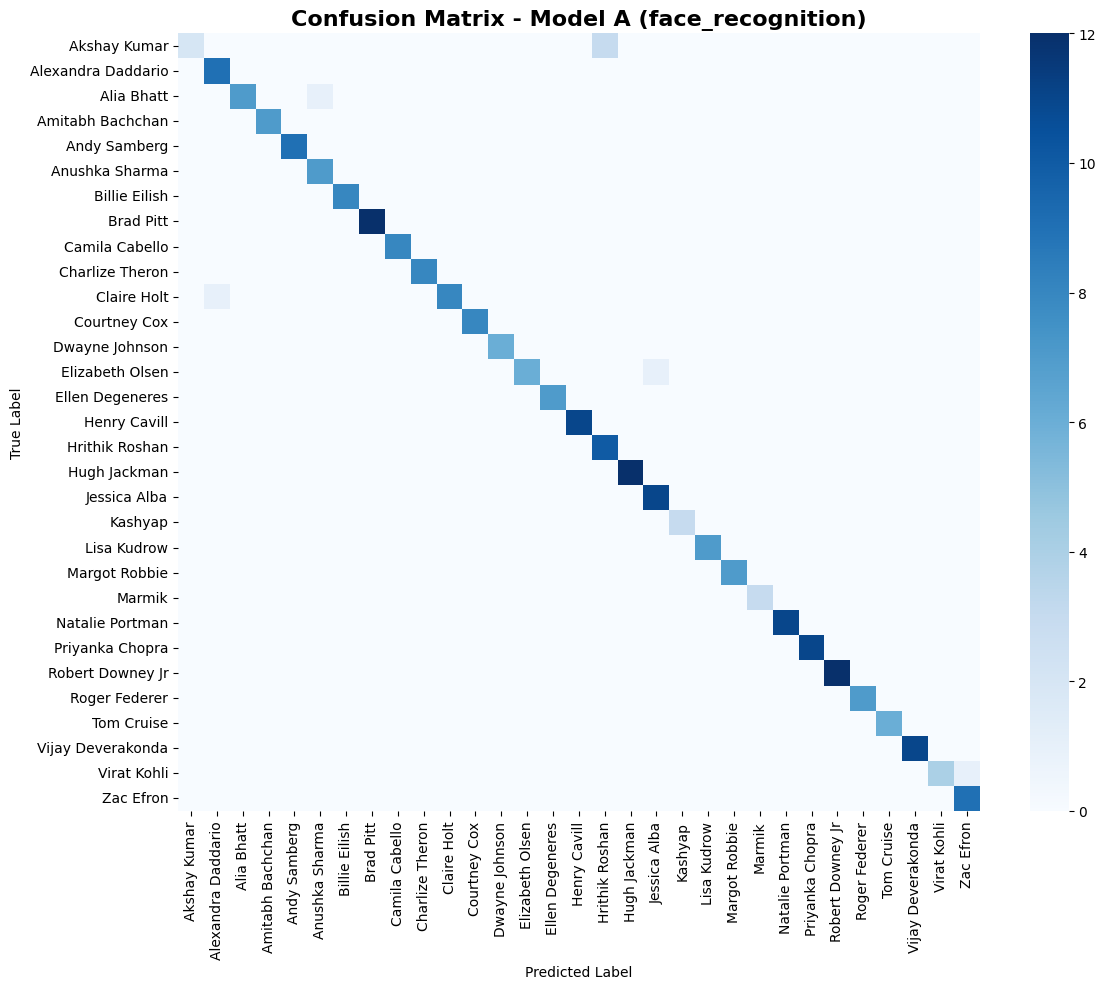

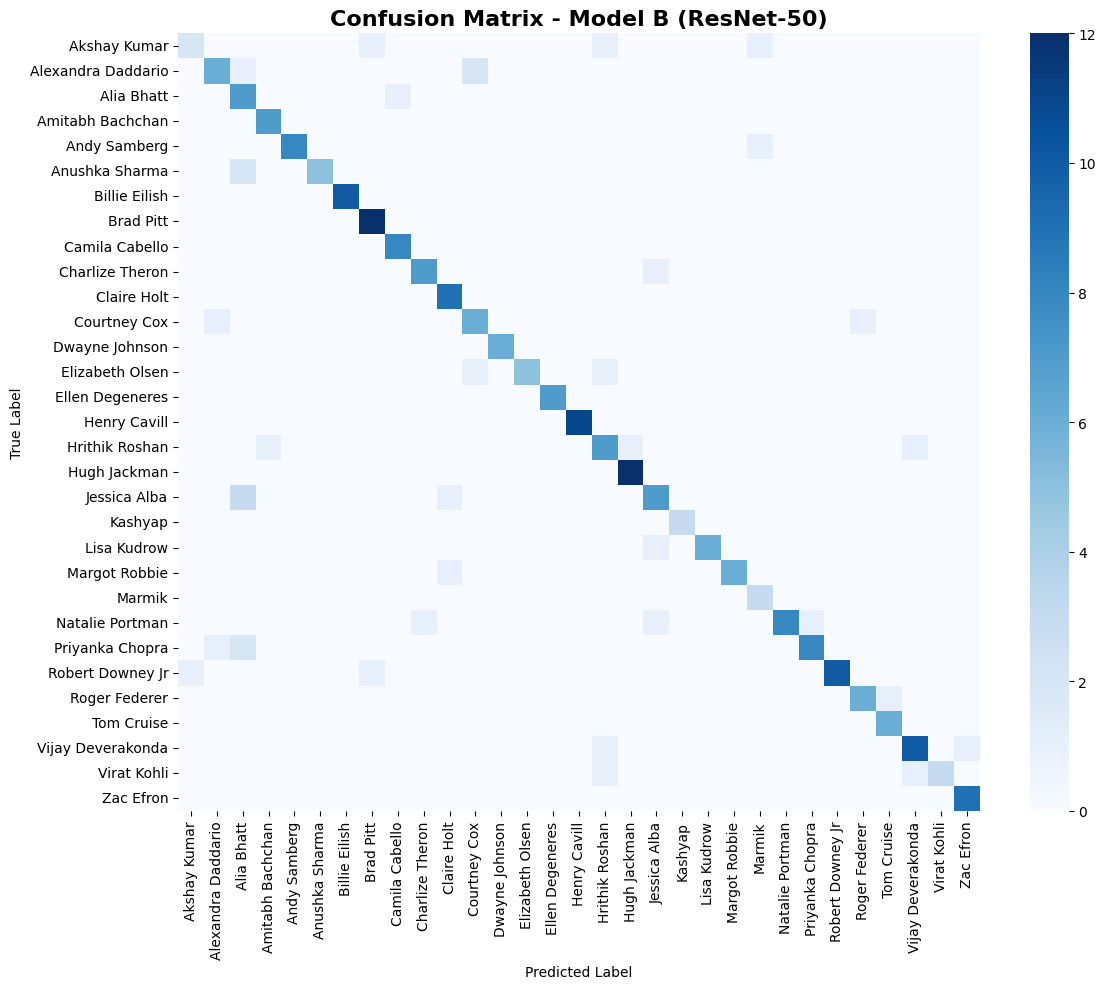

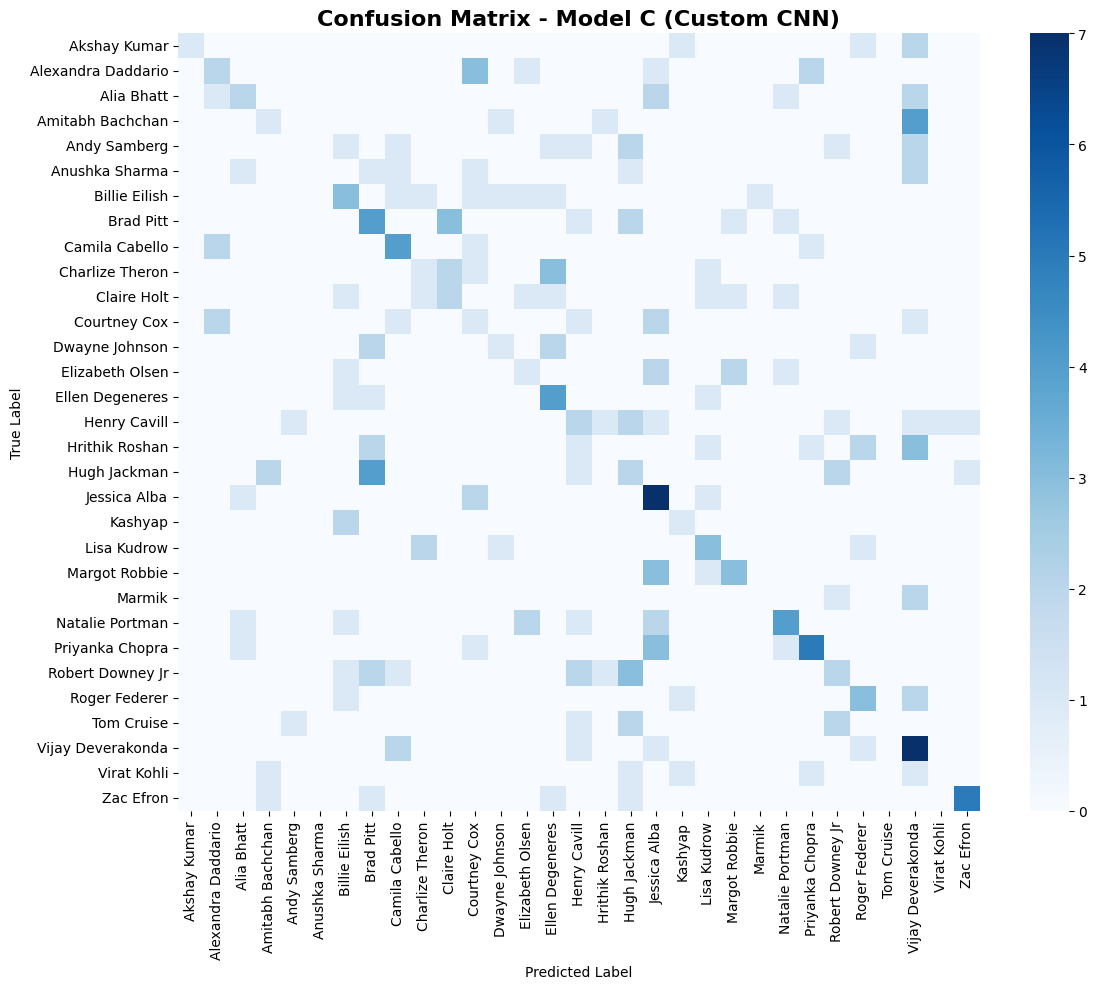

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, idx_to_name, model_name):
    """Plots a confusion matrix with label names."""
    cm = confusion_matrix(y_true, y_pred, labels=list(idx_to_name.keys()))
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=[idx_to_name[i] for i in range(len(idx_to_name))],
                yticklabels=[idx_to_name[i] for i in range(len(idx_to_name))])
    plt.title(f"Confusion Matrix - {model_name}", fontsize=16, fontweight='bold')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Confusion Matrix for Model A
plot_confusion_matrix(ya_true, ya_pred, idx_to_name, "Model A (face_recognition)")

# Confusion Matrix for Model B
plot_confusion_matrix(yb_true, yb_pred, idx_to_name, "Model B (ResNet-50)")

# Confusion Matrix for Model C
plot_confusion_matrix(yc_true, yc_pred, idx_to_name, "Model C (Custom CNN)")

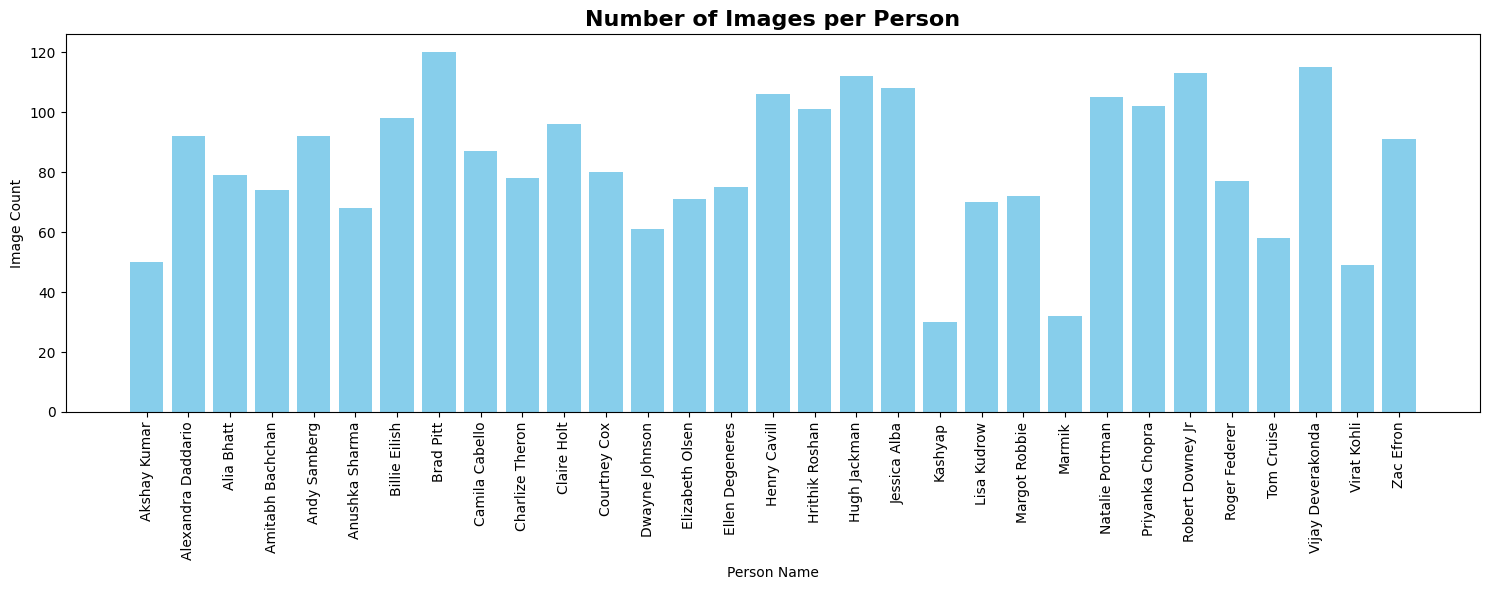

📊 Dataset Summary:
- Total Images: 2562
- Total People: 31
- Average Images per Person: 82.65
- Min Samples per Person: 30
- Max Samples per Person: 120


In [6]:
# Count images per person
from collections import Counter

label_counts = Counter(name_labels)
names = list(label_counts.keys())
counts = list(label_counts.values())

# Plot: Number of images per person
plt.figure(figsize=(15, 6))
plt.bar(names, counts, color='skyblue')
plt.xticks(rotation=90)
plt.title("Number of Images per Person", fontsize=16, fontweight='bold')
plt.xlabel("Person Name")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

# Summary statistics
print("📊 Dataset Summary:")
print(f"- Total Images: {len(paths)}")
print(f"- Total People: {len(set(name_labels))}")
print(f"- Average Images per Person: {np.mean(counts):.2f}")
print(f"- Min Samples per Person: {np.min(counts)}")
print(f"- Max Samples per Person: {np.max(counts)}")
